<img src="logo.png"/>

# Modelling Structured Illumination Microscopy in Python

We are familiar with the classic image formation model:
$$D(x,y)= S(x,y) \cdot E(x,y) \otimes PSF(x,y)$$
where $D(x,y)$ is the image formed on the camera, $S(x,y)$ is the distribution of Fluorophores in the sample, $E(x,y)$ is the intensity of the excitation light and $PSF(x,y)$ is the Point Spread Function of the system. To begin with we will reduce this to a single dimension, i.e. make the image formation only a function of the single coordinate x.

For conventional SIM we use a sinusoidal illumination pattern given by:

$$ E_i(x) = 1+m \cdot \cos(2 \pi k_0x + \phi _i)$$

where $m$ is the modulation depth of the pattern; $k_0$ is the spatial frequency of the stripe pattern; and $\phi _i$ is the phase shift of the $i^{th}$ pattern. Under ideal conditions, m is close to 1 and $n$ phase shifts are chosen such that $\phi _i = i \frac{2 \pi}{n}$. In the LAG all the SIM systems use $n=3$ although outside LAG $n=5$ is also commonly used. 
Plotting these componnets gives us:

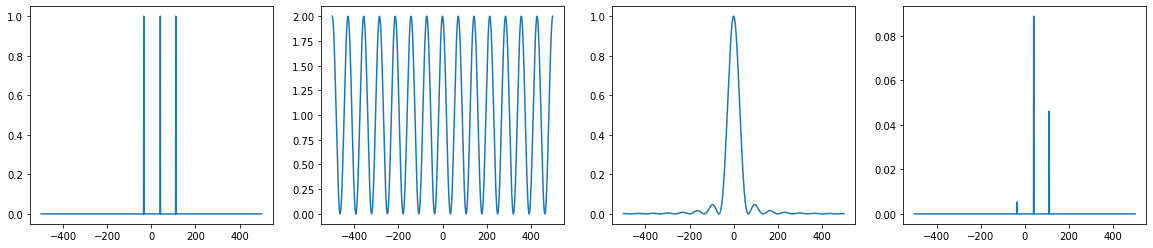

In [3]:
#As always we begin by importing the packages we will need
import numpy as np
from matplotlib import pyplot as plt
N = 1000
k0 = 14

Xs = np.linspace(-500,500,N)

Sample = np.zeros(N)
Sample[465] = 1
Sample[540] = 1
Sample[610] = 1

Excitation = 1+np.cos(2*np.pi*k0*Xs) # We know our excitation pattern follows a sinusoidal distribution with spatial frequency Kx
PSF = np.sinc(0.015*Xs)**2 # The incoherent PSF of the system can be approximated to a sinc^2 function

Emission = Sample*Excitation # This gives the expected fluoresence emission in the sample

plt.figure(figsize=(20, 4))
plt.subplot(1,4, 1)
plt.plot(Xs,Sample)
plt.subplot(1, 4, 2)
plt.plot(Xs,Excitation)
plt.subplot(1, 4, 3)
plt.plot(Xs,PSF)
plt.subplot(1, 4, 4)
plt.plot(Xs,Emission)
plt.show()

## SIM in frequency space
So now we have these defined we can begin to demonstrate the SIM process. The first step is to move into frequency space where the SIM method becomes more intuitive. From the Fourier transforms of:
$$D_i(x)= [S(x) \cdot  E_i(x)] \otimes PSF(x)$$
$$E_i(x) = 1+m \cdot \cos(2 \pi k_0x + \phi _i)$$

we get in frequency space:
$$ \tilde{D}_i(k_x)= [\tilde{S}(k_x) \otimes \tilde{E}_i(k_x)] \cdot OTF(k_x)$$
$$ \tilde{E}_i(x) = \delta(k_x) + \frac{m}{2} \delta(k_x + k_0)e^{i \cdot \phi _i} + \frac{m}{2} \delta(k_x - k_0)e^{-i \cdot \phi _i} $$

Which combine to:
$$ \tilde{D}_i(k_x)= [\tilde{S}(k_x) + \frac{m}{2}\tilde{S}(k_x+k_0)e^{-i \cdot \phi _i} + \frac{m}{2}\tilde{S}(k_x-k_0)e^{i \cdot \phi _i}] \cdot OTF(k_x)$$

Here our expressions have become a function of the spatial frequecny $k_x$. The image detected is now clearly contains a superposition of three regions of the sample's frequecny space shifted by $k_x=0 , +k_0 , -k_0 $ where the strength of the shifted components is dependant on the modulation depth, $m$, of the pattern. This is why a higher modulation depth results in improved SIM images.

We can visualise these using the fft library from the numpy package.



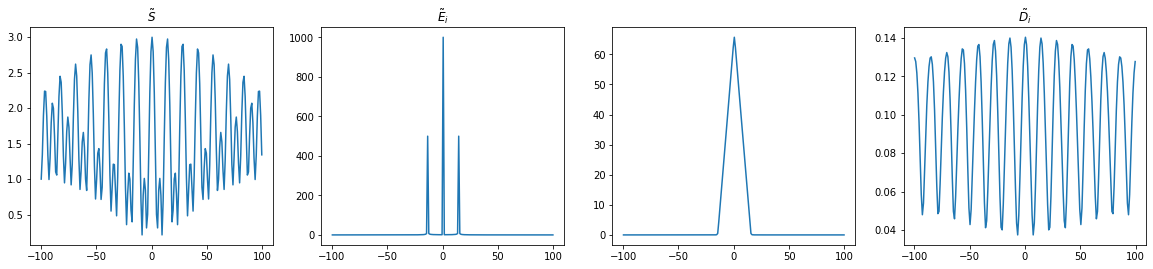

In [4]:
from numpy import fft

FTs = (np.fft.fft(Sample))
FTe = (np.fft.fft(Excitation))
FTd = np.fft.fft(Emission)
OTF = np.zeros(N)
OTF = np.fft.fftshift(np.fft.fft(PSF))

# The FFT algorithm outputs a matrix with the outer elements towards the centre
# This is corrected for using the fftshift function

FTs = np.fft.fftshift(FTs)
FTe = np.fft.fftshift(FTe)

FTd = np.fft.fftshift(FTd)

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.plot(Xs[400:600],np.abs(FTs[400:600]))
plt.title(r'$\tilde{S}$')
plt.subplot(1, 4, 2)
plt.plot(Xs[400:600],np.abs(FTe[400:600]))
plt.title(r'$\tilde{E}_i$')
plt.subplot(1, 4, 3)
plt.plot(Xs[400:600],np.abs(OTF[400:600]))
plt.subplot(1, 4, 4)
plt.plot(Xs[400:600],np.abs(FTd[400:600]))
plt.title(r'$\tilde{D}_i$')
plt.show()

# Also note how we can use TeX to include equations in matplotlib plots
# The standard TeX notation ('$ TeX_script $') applies although strings must be proceeded by r

As we can see, the sharp edges in the sample produce a continuous spatial frequecny distribution extending over the entire frequency space. Comparing $\tilde(S)$ to the Fourier transform of the acquired signal, $\tilde{D}$, we can see that what we have measured contains three copies of the samples frequency space.  

So now we have these defined we can begin to demonstrate the SIM process. If we consider the case where we use the standard three phase shifts we can describe the images we obtain:
$$\begin{bmatrix} \tilde{D}_1(k_x)\\ \tilde{D}_2(k_x)\\ \tilde{D}_3(k_x) \end{bmatrix} 
= \textbf{M} \begin{bmatrix} \tilde{S}(k_x) \cdot OTF(k_x)\\ \tilde{S}(k_x+ k_0) \cdot OTF(k_x) \\ \tilde{S}(k_x-k_0) \cdot OTF(k_x) \end{bmatrix}$$
where we have defined the _modulation matrix_:

$$ \textbf{M} = \begin{bmatrix} 1 & \frac{m}{2}e^{-i \phi _1} & \frac{m}{2}e^{i \phi _1}\\
1 & \frac{m}{2}e^{-i \phi _2} & \frac{m}{2}e^{i \phi _2}\\
1 & \frac{m}{2}e^{-i \phi _3} & \frac{m}{2}e^{i \phi _3}\end{bmatrix}$$

This leads us to:
$$ \textbf{M}^{-1} \begin{bmatrix} \tilde{D}_1(k_x)\\ \tilde{D}_2(k_x)\\ \tilde{D}_3(k_x) \end{bmatrix} 
= \begin{bmatrix} \tilde{S}(k_x) \cdot OTF(k_x)\\ \tilde{S}(k_x+ k_0) \cdot OTF(k_x) \\ \tilde{S}(k_x-k_0) \cdot OTF(k_x) \end{bmatrix}$$


<function matplotlib.pyplot.show(*args, **kw)>

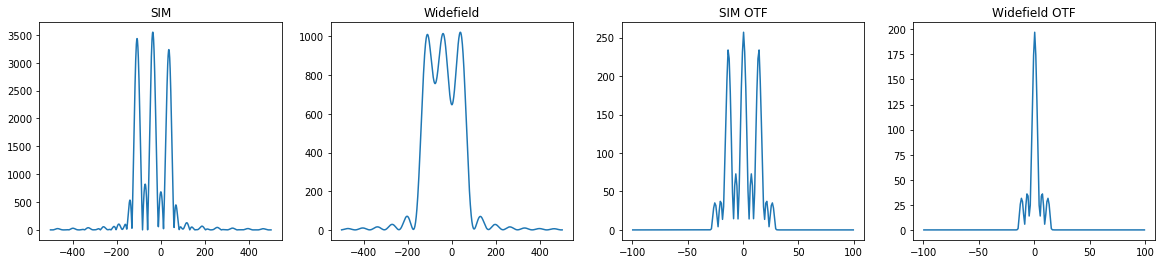

In [5]:
phi = 2*np.pi/3
Eo = 1+np.cos(2*np.pi*k0*Xs)
Em = 1+np.cos(2*np.pi*k0*Xs+phi)
Ep = 1+np.cos(2*np.pi*k0*Xs+(2*phi))

M = np.array([[1, 0.5*np.exp(0), 0.5*np.exp(0)],[1, 0.5*np.exp(-1j*phi), 0.5*np.exp(1j*phi)], [1, 0.5*np.exp(-1j*2*phi), 0.5*np.exp(1j*2*phi)]]) 
Minv = np.linalg.inv(M) 

D1 = Sample*Eo
D2 = Sample*Em
D3 = Sample*Ep

FTD1 = np.fft.fftshift(np.fft.fft(D1))*OTF
FTD2 = np.fft.fftshift(np.fft.fft(D2))*OTF
FTD3 = np.fft.fftshift(np.fft.fft(D2))*OTF

Dmat = np.array([[FTD1],[FTD2],[FTD3]])


shiftedo = Dmat[0,:]*Minv[0,0]+Dmat[1,:]*Minv[0,1]+Dmat[2,:]*Minv[0,2]
shiftedo = np.squeeze(shiftedo)
    
unshiftedm = Dmat[0,:]*Minv[1,0]+Dmat[1,:]*Minv[1,1]+Dmat[2,:]*Minv[1,2]
unshiftedm = np.squeeze(unshiftedm)
   
unshiftedp = Dmat[0,:]*Minv[2,0]+Dmat[1,:]*Minv[2,1]+Dmat[2,:]*Minv[2,2]
unshiftedp = np.squeeze(unshiftedp)

shiftedm = np.roll(unshiftedp,k0)
shiftedp = np.roll(unshiftedp,-k0)


FTfinal = shiftedo+(shiftedm)+(shiftedp)

final =np.fft.fftshift(np.fft.fft(FTfinal))

plt.figure(figsize=(20, 4))
plt.subplot(1,4,1)
plt.plot(Xs,np.abs(final))
plt.title('SIM')

plt.subplot(1,4,2)
plt.plot(Xs,np.abs(np.fft.fftshift(np.fft.fft(FTs*OTF))))
plt.title('Widefield')

plt.subplot(1,4,3)
plt.plot(Xs[400:600],np.abs(FTfinal)[400:600])
plt.title('SIM OTF')

plt.subplot(1,4,4)
plt.plot(Xs[400:600],np.abs(FTs*OTF)[400:600])
plt.title('Widefield OTF')

plt.show

# Maximum likelihood deconvolution for SIM

This matrix/component shift method essentially hasn't changed since the first SIM paper and is currently the most common technique for reconstructing SIM data; in fact it's the only method SIM user will ever be exposed to. However, there is a completely different technique we can use to reconstruct SIM data: Maximum Likelihood Estimation (MLE).

MLE is an inherently statistical approach to reconstruting SIM data and, as the name suggests, outputs an estimate of the sample based on probabiliteis rather the analytical method we have seen above. We will consider one of the simplest approaches here, the sample-only Richardson Lucy estimation.

As before we have some raw SIM data given by:
$$D_i(x)= [S(x) \cdot  E_i(x)] \otimes PSF(x) + N(x)$$
but we have added a noise term $N(x)$. Now we take a differnt approach and reframe the reconstruction as a statistics problem. Thinking back to Secondary school maths we have Bayes' theorem given by:
$$P(X|d_1,d_2...d_N) = \frac{(d_1,d_2...d_N|x)\cdot P(x)}{P(d_1,d_2...d_N)}$$

where $P(X|d_1,d_2...d_N)$ is the probability of x being the origing of some observations $d_1,d_2...d_N)$. In the context of SIM we want to to find the maximum of this probability where x is our our estimate $S_e(x)$ of the sample $S(x)$ and $d_1,d_2...d_N$ is the collecion of our raw images $D_i(x)$. We can refrase this probability maximisation as the minimisation of an error function $E$ which is simply the negative logarithm of this equation giving:
$$ E = -\ln{S_e(x)|D_i(x))} = - \ln{D_i(x)|S_e(x)} - \ln{S(x)} = L+F$$

The first term $L = - \ln{D_i(x)|S_e(x)}$ can be calcuated by taking the sum of the negative logarithms of the probabilities of making each observation $D_i(x)$ in the presence of Poisson noise and Gaussian noise with a variance $\sigma^2$ given our estimate of the sample. Skipping the derivation this is calculated from: 
$$ P(D_i(x)|S_e(x),\sigma^2) =\frac{e^{\mu+\sigma^2} \cdot (\mu+\sigma^2)^{\mu+\sigma^2}}{(\mu+\sigma^2)!},$$











Before we get started lets import all the standard libraries and a test image to work on

In [6]:
import skimage
from skimage import io
from helperFunctions import *

NA = 1.49
p_size = 40
wavelength = 600

Io = skimage.io.imread('lena.png')
Io= Io.astype('float')
w,h = Io.shape
Io = Io/np.amax(Io)

# Let's edge taper the image too since we'll be doing a lot of work in Fourier space
Io = edgeTaper(Io,drawGauss(10,10))

# And setup some key components for the calculations 
x = np.linspace(-(w*p_size)/2,(w*p_size)/2,w)
y = np.linspace(-(w*p_size)/2,(w*p_size)/2,h)
# This provides us with two helpful matrices we can use as a grid of x,y co-ordinates
X,Y = np.meshgrid(x,y)
 
# And finall use the fast OTF approximator in our heperFunctions library     
OTF = getSimpleOTF(w,p_size,NA,wavelength)
OTF = np.fft.fftshift(OTF)


Now we have these we can begin to simulate some microscope images:

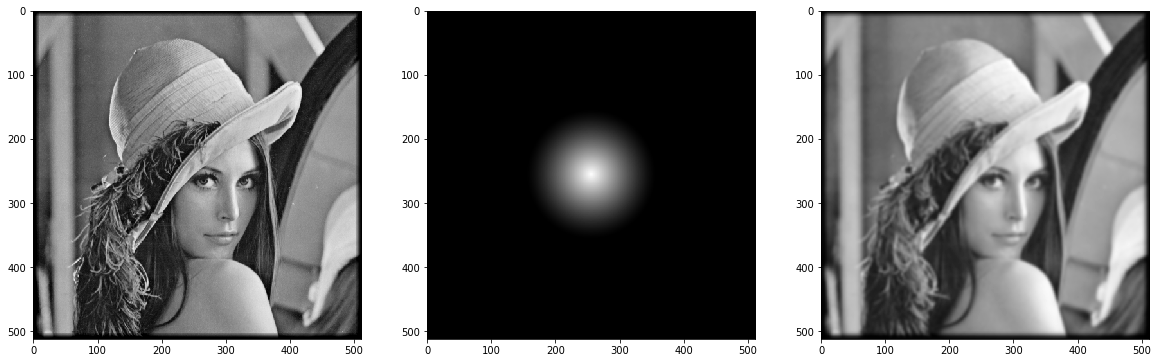

In [7]:

# We calculate the diffraction-limited image from convolution with the PSF
FTs = np.fft.fft2(Io)
FTs = np.fft.fftshift(FTs)
FT = OTF*FTs
D = abs(np.fft.ifft2(np.fft.fftshift(FT)))
D = D/np.amax(D)

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(Io, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(OTF,cmap='gray')

plt.subplot(1,3,3)
plt.imshow(D,cmap='gray')
plt.show()


Next we need to simulate some SIM images.



In [8]:
dkxy = (2*np.pi)/(w*p_size)
kMax = 2*(2*np.pi*NA)/(wavelength*dkxy)
print(kMax)
k0 = 1.2*kMax/(2*np.pi*w)
m = 1
print(k0)

101.71733333333334
0.03794253843310785


In [9]:
E = np.zeros([w,h,9])
D = np.zeros([w,h,9])

for a in range(3):
    angle = a*2*np.pi/3 + 0.2
    #print(angle)
    for p in range(3):
        phase = p*2*np.pi/3
        kx = np.cos(angle)*k0
        ky = np.sin(angle)*k0

        E[:,:,(a*3)+p] = 1+m*np.cos(kx*X+ky*Y+phase)
        D[:,:,(a*3)+p] = Io*E[:,:,(a*3)+p]
        FTs = np.fft.fft2(D[:,:,(a*3)+p])
        FTs = np.fft.fftshift(FTs)
        FT = OTF*FTs
        D[:,:,(a*3)+p] = abs(np.fft.ifft2(np.fft.fftshift(FT)))
        
D = D/np.amax(D)
        

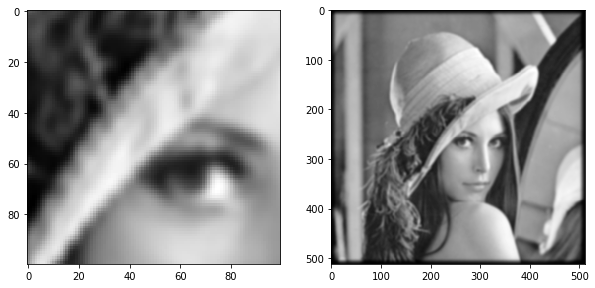

In [10]:
plt.figure(figsize=(10, 10))
estimate = np.mean(D,2)

plt.subplot(1,2,1)
plt.imshow(D[200:300,200:300,1],cmap='gray')

plt.subplot(1,2,2)
plt.imshow(estimate,cmap='gray')
plt.show()


In [11]:
n_iter = 40
frames = D.shape[2]
sigma = 0.00001
estimate = np.mean(D,2)
wf = np.mean(D,2)

for i in range(n_iter):
    intermediate = np.zeros([w,h])
    for f in range(frames):
        
        temp = estimate*E[:,:,f]
        temp = np.fft.fftshift(np.fft.fft2(temp))
        temp = abs(np.fft.ifft2(np.fft.fftshift(temp*OTF)))                  
        temp = (D[:,:,f]+sigma)/(temp+sigma)              
        temp = np.fft.fftshift(np.fft.fft2(temp))
        temp = np.abs(np.fft.ifft2(np.fft.fftshift(temp*OTF)))
        intermediate += temp*E[:,:,f]
        
    estimate = estimate*intermediate 


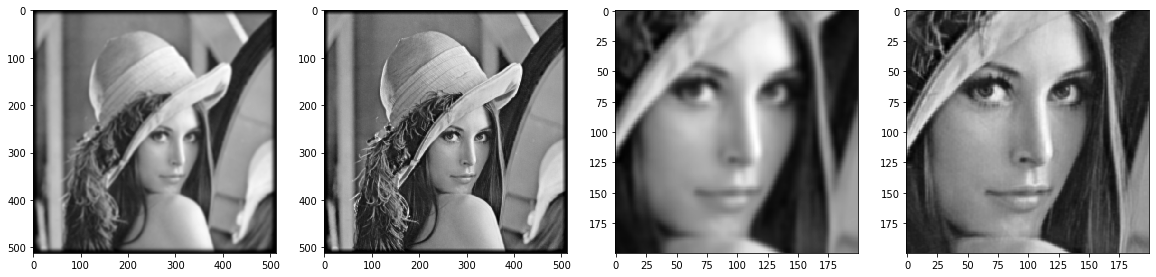

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(1,4,1)
plt.imshow(wf,cmap='gray')

plt.subplot(1,4,2)
plt.imshow(estimate,cmap='gray')

plt.subplot(1,4,3)
plt.imshow(wf[200:400,200:400],cmap='gray')

plt.subplot(1,4,4)
plt.imshow(estimate[200:400,200:400],cmap='gray')


plt.show()  

# Exercises:

These Richardson Lucy iterations are incredibly slow. The exercise this time is to speed the proces up as much as possible. 